In [1]:
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsapi

# import torch
# import torch.nn as nn
# import torch.nn.functional as F
# from torch.utils import data

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score

import warnings
warnings.filterwarnings('ignore')

In [50]:
import datetime

yesterday = (datetime.datetime.today() - datetime.timedelta(days = 1)).strftime("%m_%d_%Y")
today = datetime.datetime.today().strftime("%m_%d_%Y")

In [51]:
hits = pd.concat([pd.read_csv("player_stats_08_06_2019.csv"),
                  pd.read_csv("player_stats_08_05_2019.csv"),
                  pd.read_csv("player_stats_08_06_2019.csv"),
                  pd.read_csv("player_stats_08_07_2019.csv"),
                  pd.read_csv("player_stats_08_08_2019.csv"),
                 ], sort=False)

In [52]:
hits.set_index(np.arange(len(hits)), inplace=True)

In [53]:
hits['player_got_hit'] = hits['player_got_hit'].apply(float)

In [54]:
hits

,Name,ID,Team,gamesPlayed,groundOuts,runs,doubles,triples,homeRuns,strikeOuts,...,whip_p5G,winPercentage_p5G,atBats_h2h,avg_h2h,hits_h2h,obp_h2h,ops_h2h,slg_h2h,pitcher_hitter_opposite_hand,player_got_hit
0,Brandon Dixon,641525,116,81.0,46.0,32.0,12.0,3.0,14.0,87.0,...,1.54,0.20,5.0,0.200,1.0,0.333,0.933,0.600,0.0,1.0
1,Dawel Lugo,608475,116,31.0,31.0,6.0,0.0,3.0,1.0,21.0,...,1.54,0.20,3.0,0.333,1.0,0.333,0.666,0.333,0.0,1.0
2,Gordon Beckham,493596,116,66.0,41.0,22.0,11.0,2.0,5.0,60.0,...,1.54,0.20,0.0,0.000,0.0,0.000,0.000,0.000,0.0,0.0
3,Harold Castro,605612,116,55.0,60.0,17.0,6.0,3.0,2.0,49.0,...,1.54,0.20,6.0,0.500,3.0,0.500,1.000,0.500,1.0,1.0
4,JaCoby Jones,592444,116,87.0,66.0,39.0,19.0,3.0,11.0,93.0,...,1.54,0.20,6.0,0.000,0.0,0.000,0.000,0.000,0.0,1.0
5,Jake Rogers,668670,116,7.0,5.0,5.0,0.0,0.0,2.0,8.0,...,1.54,0.20,2.0,0.500,1.0,0.500,2.500,2.000,0.0,1.0
6,John Hicks,543308,116,69.0,55.0,19.0,11.0,0.0,7.0,74.0,...,1.54,0.20,5.0,0.200,1.0,0.200,0.400,0.200,0.0,1.0
7,Jordy Mercer,474568,116,42.0,40.0,11.0,8.0,0.0,5.0,29.0,...,1.54,0.20,1.0,0.000,0.0,0.500,0.500,0.000,0.0,0.0
8,Miguel Cabrera,408234,116,100.0,93.0,29.0,16.0,0.0,7.0,79.0,...,1.54,0.20,0.0,0.000,0.0,0.000,0.000,0.000,0.0,0.0
9,Niko Goodrum,592348,116,101.0,71.0,54.0,24.0,4.0,10.0,123.0,...,1.54,0.20,3.0,0.333,1.0,0.600,1.267,0.667,1.0,1.0


In [55]:
data = hits.iloc[:, 3:-1]
data

,gamesPlayed,groundOuts,runs,doubles,triples,homeRuns,strikeOuts,baseOnBalls,intentionalWalks,hits,...,walksPer9Inn_p5G,whip_p5G,winPercentage_p5G,atBats_h2h,avg_h2h,hits_h2h,obp_h2h,ops_h2h,slg_h2h,pitcher_hitter_opposite_hand
0,81.0,46.0,32.0,12.0,3.0,14.0,87.0,15.0,0.0,70.0,...,3.54,1.54,0.20,5.0,0.200,1.0,0.333,0.933,0.600,0.0
1,31.0,31.0,6.0,0.0,3.0,1.0,21.0,2.0,0.0,20.0,...,3.54,1.54,0.20,3.0,0.333,1.0,0.333,0.666,0.333,0.0
2,66.0,41.0,22.0,11.0,2.0,5.0,60.0,12.0,0.0,38.0,...,3.54,1.54,0.20,0.0,0.000,0.0,0.000,0.000,0.000,0.0
3,55.0,60.0,17.0,6.0,3.0,2.0,49.0,6.0,0.0,55.0,...,3.54,1.54,0.20,6.0,0.500,3.0,0.500,1.000,0.500,1.0
4,87.0,66.0,39.0,19.0,3.0,11.0,93.0,27.0,2.0,70.0,...,3.54,1.54,0.20,6.0,0.000,0.0,0.000,0.000,0.000,0.0
5,7.0,5.0,5.0,0.0,0.0,2.0,8.0,4.0,0.0,5.0,...,3.54,1.54,0.20,2.0,0.500,1.0,0.500,2.500,2.000,0.0
6,69.0,55.0,19.0,11.0,0.0,7.0,74.0,12.0,0.0,48.0,...,3.54,1.54,0.20,5.0,0.200,1.0,0.200,0.400,0.200,0.0
7,42.0,40.0,11.0,8.0,0.0,5.0,29.0,8.0,1.0,36.0,...,3.54,1.54,0.20,1.0,0.000,0.0,0.500,0.500,0.000,0.0
8,100.0,93.0,29.0,16.0,0.0,7.0,79.0,32.0,2.0,104.0,...,3.54,1.54,0.20,0.0,0.000,0.0,0.000,0.000,0.000,0.0
9,101.0,71.0,54.0,24.0,4.0,10.0,123.0,43.0,1.0,96.0,...,3.54,1.54,0.20,3.0,0.333,1.0,0.600,1.267,0.667,1.0


In [56]:
labels = hits.iloc[:, -1]
labels

0       1.0
1       1.0
2       0.0
3       1.0
4       1.0
5       1.0
6       1.0
7       0.0
8       0.0
9       1.0
10      0.0
11      1.0
12      1.0
13      0.0
14      0.0
15      0.0
16      1.0
17      1.0
18      0.0
19      1.0
20      1.0
21      1.0
22      1.0
23      1.0
24      1.0
25      1.0
26      1.0
27      1.0
28      1.0
29      0.0
       ... 
1640    0.0
1641    0.0
1642    0.0
1643    0.0
1644    0.0
1645    0.0
1646    0.0
1647    1.0
1648    1.0
1649    1.0
1650    0.0
1651    0.0
1652    0.0
1653    0.0
1654    1.0
1655    0.0
1656    1.0
1657    1.0
1658    1.0
1659    0.0
1660    1.0
1661    0.0
1662    0.0
1663    1.0
1664    0.0
1665    1.0
1666    1.0
1667    1.0
1668    1.0
1669    1.0
Name: player_got_hit, Length: 1670, dtype: float64

In [79]:
# data_train, data_test, labels_train, labels_test = train_test_split(data, labels, test_size=0.2)
data_train, data_val, labels_train, labels_val = train_test_split(data, labels, test_size=0.2)

In [80]:
np.mean(labels_train == 0)

0.49700598802395207

In [81]:
np.mean(labels_train == 1)

0.5029940119760479

In [60]:
hits.columns

Index(['Name', 'ID', 'Team', 'gamesPlayed', 'groundOuts', 'runs', 'doubles',
       'triples', 'homeRuns', 'strikeOuts', 'baseOnBalls', 'intentionalWalks',
       'hits', 'hitByPitch', 'avg', 'atBats', 'obp', 'slg', 'ops',
       'caughtStealing', 'stolenBases', 'stolenBasePercentage',
       'groundIntoDoublePlay', 'numberOfPitches', 'plateAppearances',
       'totalBases', 'rbi', 'leftOnBase', 'sacBunts', 'sacFlies', 'babip',
       'groundOutsToAirouts', 'atBatsPerHomeRun', 'atBatsPerHomeRun_p7G',
       'avg_p7G', 'hits_p7G', 'obp_p7G', 'ops_p7G', 'slg_p7G',
       'atBatsPerHomeRun_p15G', 'avg_p15G', 'hits_p15G', 'obp_p15G',
       'ops_p15G', 'slg_p15G', 'avg_p5G', 'era_p5G', 'groundOutsToAirouts_p5G',
       'hitsPer9Inn_p5G', 'homeRunsPer9_p5G', 'inningsPitched_p5G',
       'pitchesPerInning_p5G', 'runsScoredPer9_p5G',
       'stolenBasePercentage_p5G', 'strikePercentage_p5G',
       'strikeoutWalkRatio_p5G', 'strikeoutsPer9Inn_p5G', 'walksPer9Inn_p5G',
       'whip_p5G', 'winP

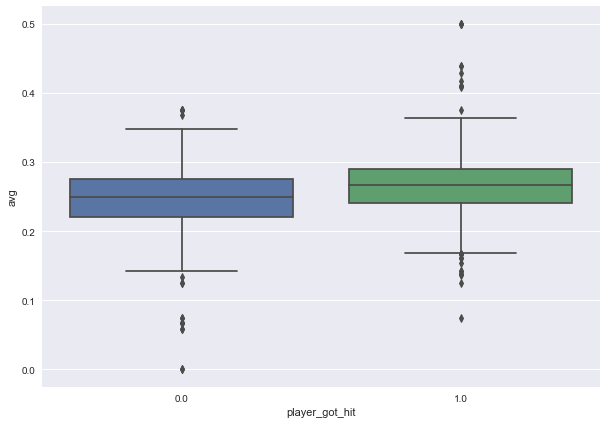

In [61]:
plt.figure(figsize=(10, 7))
sns.boxplot(x = "player_got_hit", y = "avg", data=hits)

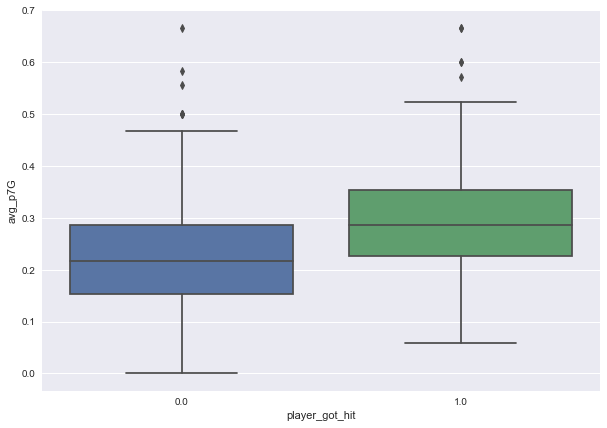

In [62]:
plt.figure(figsize=(10, 7))
sns.boxplot(x = "player_got_hit", y = "avg_p7G", data=hits)

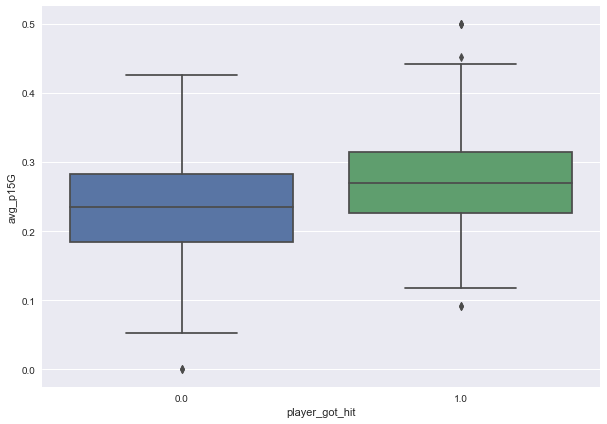

In [63]:
plt.figure(figsize=(10, 7))
sns.boxplot(x = "player_got_hit", y = "avg_p15G", data=hits)

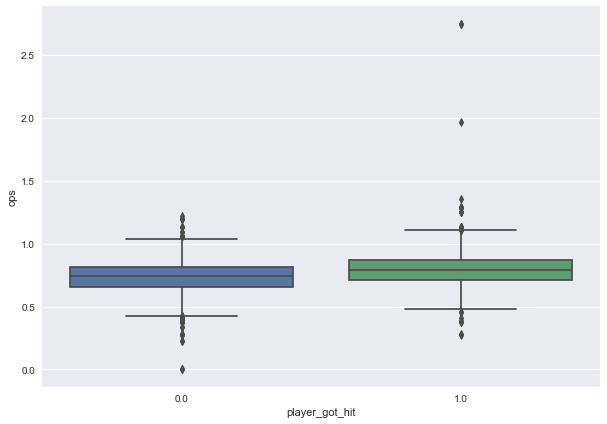

In [64]:
plt.figure(figsize=(10, 7))
sns.boxplot(x = "player_got_hit", y = "ops", data=hits)

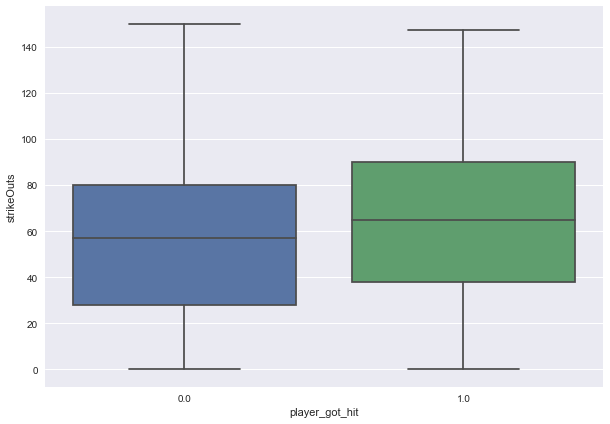

In [65]:
plt.figure(figsize=(10, 7))
sns.boxplot(x = "player_got_hit", y = "strikeOuts", data=hits)

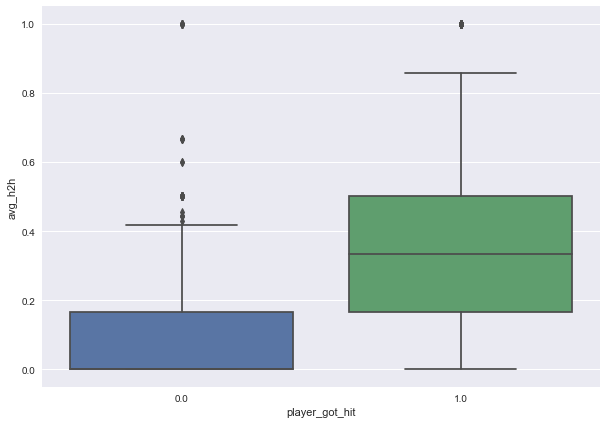

In [66]:
plt.figure(figsize=(10, 7))
sns.boxplot(x = "player_got_hit", y = "avg_h2h", data=hits)

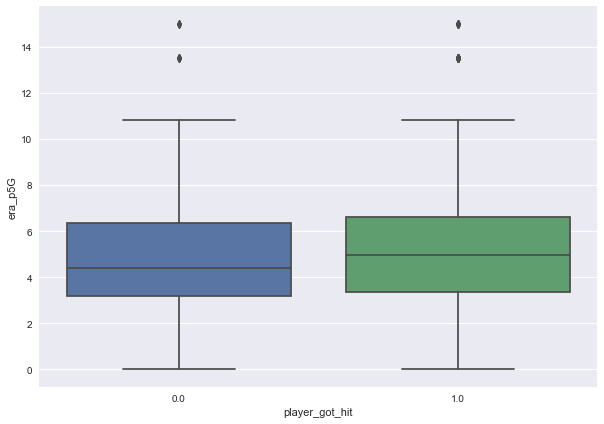

In [67]:
plt.figure(figsize=(10, 7))
sns.boxplot(x = "player_got_hit", y = "era_p5G", data=hits)

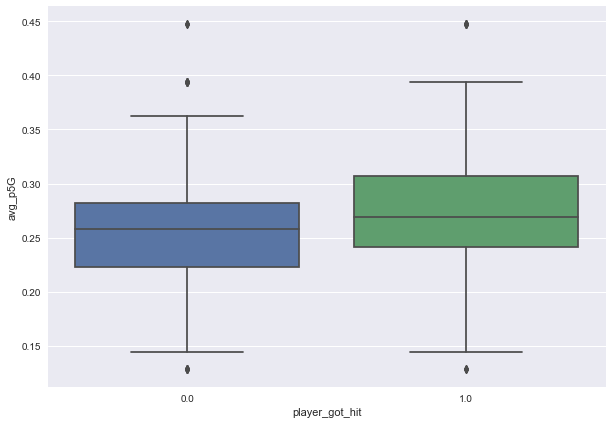

In [68]:
plt.figure(figsize=(10, 7))
sns.boxplot(x = "player_got_hit", y = "avg_p5G", data=hits)

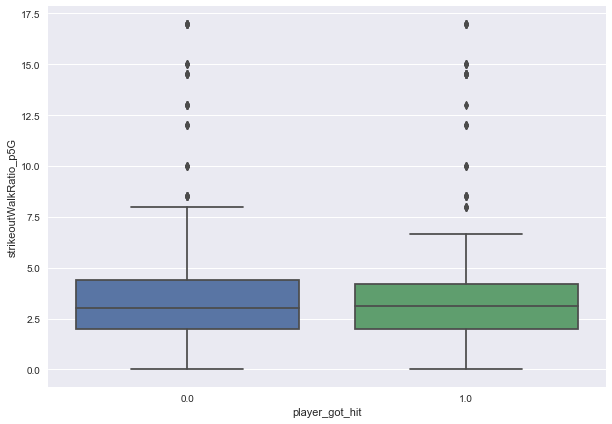

In [69]:
plt.figure(figsize=(10, 7))
sns.boxplot(x = "player_got_hit", y = "strikeoutWalkRatio_p5G", data=hits)

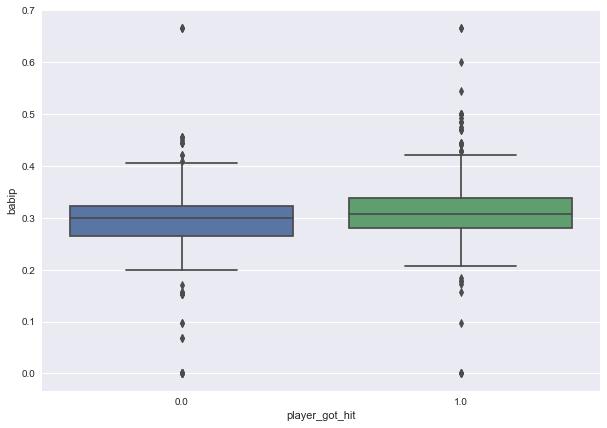

In [70]:
plt.figure(figsize=(10, 7))
sns.boxplot(x = "player_got_hit", y = "babip", data=hits)

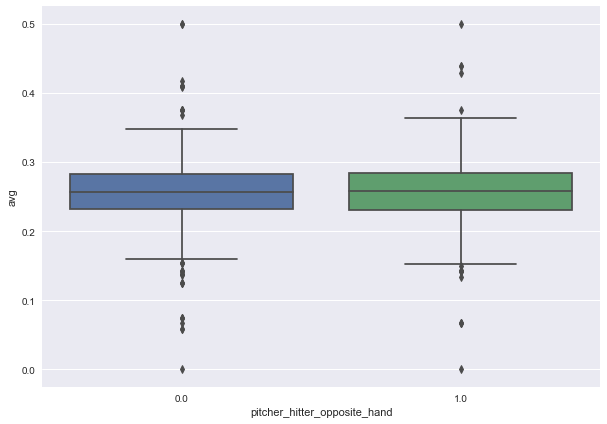

In [71]:
plt.figure(figsize=(10, 7))
sns.boxplot(x = "pitcher_hitter_opposite_hand", y = "avg", data=hits)

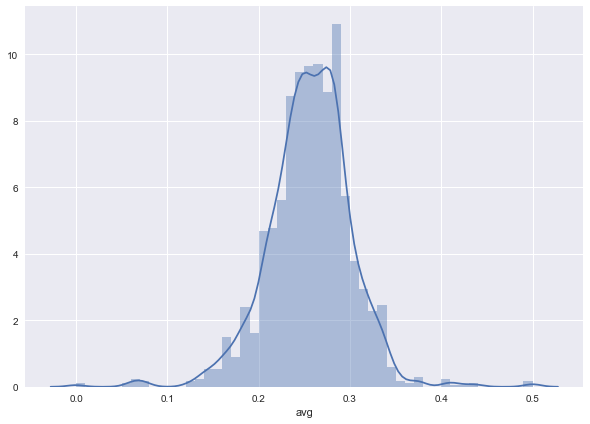

In [72]:
plt.figure(figsize=(10, 7))
sns.distplot(hits['avg'])

In [82]:
logreg = LogisticRegression(penalty='l2').fit(data_train, labels_train)

In [83]:
np.mean(logreg.predict(data_train) == labels_train)

0.7784431137724551

In [84]:
np.mean(logreg.predict(data_val) == labels_val)

0.7365269461077845

In [85]:
hits.take(data_val.take(np.argsort(logreg.predict_proba(data_val)[:, 1])[::-1][:20]).index)['Name']

848     Aristides Aquino
119     Aristides Aquino
1496         Gio Urshela
1457       David Peralta
89           DJ LeMahieu
77       Jonathan Villar
1486       Reese McGuire
999      Jonathan Schoop
582       Yolmer Sanchez
429       Harold Ramirez
531           Mike Trout
1557         Kyle Farmer
123        Jose Iglesias
847      Whit Merrifield
547          Bo Bichette
426        Bryan Holaday
262         Trevor Story
665          Ketel Marte
613          Javier Baez
335          Kurt Suzuki
Name: Name, dtype: object

In [86]:
hits_test = pd.read_csv("player_stats_{}.csv".format(today))
hits_test.head()

,Name,ID,Team,gamesPlayed,groundOuts,runs,doubles,triples,homeRuns,strikeOuts,...,walksPer9Inn_p5G,whip_p5G,winPercentage_p5G,atBats_h2h,avg_h2h,hits_h2h,obp_h2h,ops_h2h,slg_h2h,pitcher_hitter_opposite_hand
0,Adam Engel,641553,145,44.0,19.0,11.0,4.0,2.0,2.0,38.0,...,3.24,1.26,1.0,5.0,0.400,2.0,0.400,0.800,0.400,0.0
1,Eloy Jimenez,650391,145,78.0,80.0,40.0,8.0,0.0,18.0,89.0,...,3.24,1.26,1.0,3.0,0.333,1.0,0.333,0.666,0.333,0.0
2,James McCann,543510,145,84.0,69.0,45.0,19.0,0.0,12.0,97.0,...,3.24,1.26,1.0,8.0,0.250,2.0,0.400,0.650,0.250,0.0
3,Jon Jay,445055,145,31.0,40.0,11.0,8.0,0.0,0.0,22.0,...,3.24,1.26,1.0,23.0,0.261,6.0,0.261,0.522,0.261,1.0
4,Jose Abreu,547989,145,112.0,122.0,55.0,24.0,0.0,24.0,109.0,...,3.24,1.26,1.0,18.0,0.167,3.0,0.211,0.489,0.278,0.0


In [87]:
data_test = hits_test.iloc[:, 3:]

In [88]:
hits_test.take(np.argsort(logreg.predict_proba(data_test)[:, 1])[::-1][:15])['Name']

310            Trevor Story
162             Jorge Soler
318           Evan Longoria
205        Francisco Lindor
66              DJ LeMahieu
265            A.J. Pollock
171             Jeff McNeil
332             Jean Segura
285             Ketel Marte
17            Marcus Semien
92             Ozzie Albies
141    Nicholas Castellanos
112             Kevan Smith
137             Javier Baez
301        Charlie Blackmon
Name: Name, dtype: object

In [89]:
precision_score(labels_val, logreg.predict(data_val))

0.7814569536423841

In [90]:
recall_score(labels_val, logreg.predict(data_val))

0.6820809248554913

In [91]:
f1_score(labels_val, logreg.predict(data_val))

0.7283950617283951

## Gradient boosted decision trees??

In [92]:
from sklearn.ensemble import AdaBoostClassifier

In [93]:
boosted_dt = AdaBoostClassifier()
boosted_dt.fit(data_train, labels_train)

AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=1.0, n_estimators=50, random_state=None)

In [94]:
np.mean(boosted_dt.predict(data_val) == labels_val)

0.7544910179640718

In [95]:
hits_test.take(np.argsort(boosted_dt.predict_proba(data_test)[:, 1])[::-1][:10])['Name']

171         Jeff McNeil
285         Ketel Marte
137         Javier Baez
92         Ozzie Albies
93     Ronald Acuna Jr.
66          DJ LeMahieu
140      Kyle Schwarber
239      Starling Marte
46       Yordan Alvarez
297          Luis Urias
Name: Name, dtype: object

In [96]:
precision_score(labels_val, boosted_dt.predict(data_val))

0.7861635220125787

In [97]:
recall_score(labels_val, boosted_dt.predict(data_val))

0.7225433526011561

In [98]:
f1_score(labels_val, boosted_dt.predict(data_val))

0.7530120481927711

## Random forests...

In [99]:
from sklearn.ensemble import RandomForestClassifier

In [101]:
# Tuning hyperparameters for random forests
# Note that cross-validation is sort of "automatically" done because 
# sklearn's implementation of random forests uses bagging for each 
# estimator -- more details here 
# https://scikit-learn.org/stable/modules/grid_search.html#out-of-bag-estimates

from sklearn.model_selection import GridSearchCV

param_grid = [
    {'criterion': ['gini'], 'max_depth': [20], 'min_samples_leaf': [4, 10, 20, 30],
    'n_estimators': [50, 75, 100, 125, 150]}
]

In [58]:
rf_cv = GridSearchCV(RandomForestClassifier(), param_grid, cv=4)
rf_cv.fit(data_train, labels_train)

GridSearchCV(cv=4, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid=[{'criterion': ['gini'], 'max_depth': [20], 'min_samples_leaf': [4, 10, 20, 30], 'n_estimators': [50, 75, 100, 125, 150]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

In [59]:
rf_cv.best_params_

{'criterion': 'gini',
 'max_depth': 20,
 'min_samples_leaf': 10,
 'n_estimators': 150}

The best parameters seem to be a Gini score criterion, a max depth per tree of 20, a minimum of 10 points per leaf node, and 100 estimators.

In [100]:
rf_classifier = RandomForestClassifier(n_estimators=150, criterion='gini', max_depth=20, min_samples_leaf=10)
rf_classifier.fit(data_train, labels_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=20, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=10,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=150, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)

In [101]:
np.mean(rf_classifier.predict(data_val) == labels_val)

0.7784431137724551

In [102]:
predictions = hits_test.take(np.argsort(rf_classifier.predict_proba(data_test)[:, 1])[::-1][:10])[['Name', 'Team']].reset_index().iloc[:, 1:]
predictions.columns = ["name", "team_id"]
predictions["team_name"] = predictions['team_id'].apply(lambda x: statsapi.lookup_team(x)[0]['name'])
predictions["hit_probability"] = np.sort(rf_classifier.predict_proba(data_test)[:, 1])[::-1][:10]
predictions.to_csv("predictions_{}.csv".format(today))

In [103]:
predictions

,name,team_id,team_name,hit_probability
0,Carlos Correa,117,Houston Astros,0.981782
1,Jose Altuve,117,Houston Astros,0.972847
2,Marcus Semien,133,Oakland Athletics,0.971461
3,Yordan Alvarez,117,Houston Astros,0.959952
4,Michael Brantley,117,Houston Astros,0.949384
5,Randal Grichuk,141,Toronto Blue Jays,0.948210
6,Javier Baez,112,Chicago Cubs,0.945452
7,Starling Marte,134,Pittsburgh Pirates,0.940158
8,Ketel Marte,109,Arizona Diamondbacks,0.928612
9,Jeff McNeil,121,New York Mets,0.925069


In [104]:
precision_score(labels_val, rf_classifier.predict(data_val))

0.8074534161490683

In [105]:
recall_score(labels_val, rf_classifier.predict(data_val))

0.7514450867052023

In [106]:
f1_score(labels_val, rf_classifier.predict(data_val))

0.778443113772455

## K-NN, because why not

In [64]:
from sklearn.neighbors import KNeighborsClassifier

In [65]:
# TODO: tune hyperparameters
knn_clf = KNeighborsClassifier(n_neighbors=7)
knn_clf.fit(data_train, labels_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=7, p=2,
           weights='uniform')

In [66]:
np.mean(knn_clf.predict(data_val) == labels_val)

0.6363636363636364

In [67]:
hits_test.take(np.argsort(knn_clf.predict_proba(data_test)[:, 1])[::-1][:10])['Name']

135      Austin Meadows
347        Kole Calhoun
191        Josh Reddick
328    Christian Yelich
253         Tommy Edman
109      Starlin Castro
146     Travis d'Arnaud
321       Marcus Semien
34        Scott Kingery
107        Miguel Rojas
Name: Name, dtype: object

## Now the fun begins

In [ ]:
num_rows = len(data)
num_feats = len(np.transpose(data))
print(num_rows)
print(num_feats)

### Convert our arrays to torch tensors

In [ ]:
data_train_t = torch.from_numpy(np.array(data_train)).type(torch.FloatTensor)
data_val_t = torch.from_numpy(np.array(data_val)).type(torch.FloatTensor)
data_test_t = torch.from_numpy(np.array(data_test)).type(torch.FloatTensor)

labels_train_t = torch.from_numpy(np.array(labels_train)).type(torch.LongTensor)
labels_val_t = torch.from_numpy(np.array(labels_val)).type(torch.LongTensor)
# labels_test_t = torch.from_numpy(np.array(labels_test)).type(torch.LongTensor)

### Then begin training

In [ ]:
class NeuralNet(nn.Module):
    def __init__(self):
        super(NeuralNet, self).__init__()
        self.classify = nn.Sequential(
            nn.Linear(num_feats, 64),
            nn.ReLU(inplace=True),
            nn.Linear(64, 32),
            nn.ReLU(inplace=True),
            nn.Linear(32, 2)
        )
        self.fc1 = nn.Linear(num_feats, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 2)
        
    def forward(self, x):
        x = self.classify(x)
        return x
    
    def predict(self, x):
        predictions = F.softmax(self.forward(x), dim=1)
        return predictions
        

In [ ]:
model = NeuralNet()

In [ ]:
# Hyperparameters
learning_rate = .001
reg_param = .001
epochs = 250

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=reg_param)

In [ ]:
losses = []
for i in range(epochs):
    outputs = model.forward(data_train_t)
    loss = criterion(outputs, labels_train_t)
    losses.append(loss.item())
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

In [ ]:
losses

In [ ]:
# Training accuracy

_, predicted = torch.max(outputs, 1)
np.mean(predicted.numpy() == labels_train)

In [ ]:
with torch.no_grad():
    val_outputs = model.forward(data_val_t)
    _, predicted_val = torch.max(val_outputs.data, 1)

In [ ]:
# Validation accuracy

np.mean(predicted_val.numpy() == labels_val)

In [ ]:
highest_probs_indices_val = np.argsort(F.softmax(val_outputs)[:, 1].numpy())[-25:][::-1]

In [ ]:
hits.take(np.array(data_val.take(highest_probs_indices_val).index))['Name']

In [ ]:
# On test data
with torch.no_grad():
    test_outputs = model.forward(data_test_t)
    _, predicted_test = torch.max(test_outputs.data, 1)

In [ ]:
highest_probs_indices_test = np.argsort(F.softmax(test_outputs)[:, 1].numpy())[-25:][::-1]

In [ ]:
hits_test.take(np.array(data_test.take(highest_probs_indices_test).index))['Name']